<h1><center>Student Monitoring System</center></h1>


In [1]:
# Import libraries
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

### Function to find the distracted student in the dictionary of students present in the class

In [9]:
# Find the distraced student based on the data present in the dictionary
# Variance for all the student coordinate data is created and put in a list. Then mean and variance of this data is
# found, The variances are normalized based on the size of the box. Greater the size of the box neaerer is the 
# student hence higher variance and vice versa. They are normalized on the basis of box size and the distraced
# student is found whose normalized variance is higher than the mean+variance of this data of normalized variances

def find_distracted (students):
        
    var_o_var = [] # To store the data of varinaces
    for s in students:
        
        nt = students [s] ['df'].values [33].tolist()
        ntx = nt [0::2]
        mean = np.mean (ntx)
        sigma = np.std (ntx)
        sigmanorm = np.std(ntx)/abs(students [s]['box'][1] - students[s]['box'][0])

        var_o_var.append (sigmanorm)
        
    sigma_s = np.std (var_o_var)
    
    mean_s = np.mean (var_o_var)
    
    disturbed = []
    #print ("threshold: ", mean_s + sigma_s)
    for i in range (len (var_o_var)):
        #print (var_o_var [i])
        if var_o_var [i] > mean_s + sigma_s:
            disturbed.append ((i+1))
            
    return disturbed
        


### Function to find the student the face found in the frame belongs to

In [10]:
students = {}

In [11]:
# Finding the student the face belongs to detected in the current frame
# The face is said to belong to some student if the new coordinates of the box have high probablity of being a part
# of that student based on the pdf (probablity distribution) formed using the prior data of the coordinates
# The face is then said to be the part of a student for whom the probablity is maximum and above the threshold
# 0.00000001 
# If the probablity does not exceed the threshold the face is said to be a new student and a new student entry is 
# made in the dictionary of students

def find_face (x1,y1,stu):
    
    maxx = 0.0 # variable
    maxy = 0.0 # variable
    sdnt = ''
    flag = 0 # Threshold satisfaction flag
    
    for s in stu:
        temp1 = norm.pdf (x1, np.mean (stu [s] ['x1']), stu [s]['sd']) # Find probablity for x coordinate
        temp2 = norm.pdf (y1 ,np.mean (stu [s] ['y1']), stu [s]['sd']) # Find probablity for y coordinate
        if (temp1 > maxx and temp1 > 0.00000001): # Check threshold for x
            maxx = temp1
            if(temp2 > maxy and temp2 > 0.00000001): # Check threshold for y
                maxy = temp2
                sdnt = s
                flag = 1 # Student found
            
    if (flag == 0): # No student found so new entry in the dictionary created
        stu [len (stu) + 1] = {'x1': [x1],'y1':[y1], 'df':pd.DataFrame (), 'sd': 10}
        return (len (stu), stu)
    
    stu [sdnt] ['x1'].append (x1)
    stu [sdnt] ['y1'].append (y1)
    return (sdnt, stu)

### Main function of the system

In [31]:
# Main function which monitors the student

def student_monitoring (n):
    
    df = pd.DataFrame()
    students = {} # Dictionary which will store the data of all students detected in the video frames
    distracted = [] # Holds the value of current distracted student

    cap = cv2.VideoCapture(0) # Start capturing the video
    detector = dlib.get_frontal_face_detector() # DLIB library face detector
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # Landmark detetctor

    for i in range (n): # Run the system for n number of frames as passed by the user
        _, frame = cap.read() # Read one frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Grayscale them

        faces = detector(gray) # Detect the faces in the frame using the DLIB face detector

        for face in faces: # For all the faces found in the frame

            x1 = face.left() # Top left x coordinate of the bounding box
            y1 = face.top() # Top left y coordinate of the bounding box
            x2 = face.right() # Bottom right x coordinate fo the bounding box
            y2 = face.bottom() # Bottom right y coordinate of the bounding box


            f, students = find_face(x1, y1, students) # Find the student the given face belongs to
            

            #print ("student (f): ", f)
            #print ("distracted: ", distracted)
            # If the given student is the distracted student found as per the prior iteration, bound the student 
            # with blue box
            if f in distracted:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)
            else:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 3)

            # Find the landmarks on the given face    
            landmarks = predictor(gray, face)
            xc = []
            yc = []
            for n in range(0, 68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                xc.append(x)
                yc.append(y)
                # Mark the landmarks on the face in the frame
                cv2.circle(frame, (x, y), 4, (255, 0, 0), -1)
            
            index = int (len (students [f] ['df'].columns) / 2)
            students [f] ['df'] ['x'+str(index)] = xc
            students [f] ['df'] ['y'+str(index)] = yc
            students [f] ['box'] = list ((x1, x2))
        
        
        cv2.imshow("Frame", frame)
        # Print the number of distinct students detected by the system
        #print (len (students))
        
        # Find the distracted student based on the current data
        distracted = find_distracted (students)
        

        key = cv2.waitKey(1)
        if key == 27:
            break

    cap.release ()
    cv2.destroyAllWindows ()
    
    print (students)
    
    # plot the distribution of nose points
    plot_distributions (students)

### Plot the probablity distribution of students woth respect to their x coordinates

In [32]:
def plot_distributions (students):

    for s in students:

        nt = students [s] ['df'].values [33].tolist()
        ntx = nt [0::2]
        ntx.sort()
        mean = np.mean (ntx)
        sigma = np.std (ntx)
        sigmanorm = np.std(ntx)/abs(students [s]['box'][1] - students[s]['box'][0])
        plt.plot (ntx, norm.pdf (ntx, mean, sigma))
        #plt.show () # Uncomment the syntax to get individual plots of each student
        
        # Comment all print statements to just get the plot
        #print (s)
        #print (ntx)
        #print (students [s]['box'][1] - students[s]['box'][0])
        #print (sigma)
        #print (sigmanorm)

    plt.show () # Comment the syntax when plotting individual plots for each student

### Run the system (Parameter value is the number of frames you want to run the system for)

{1: {'x1': [234, 234, 234, 234, 234, 234, 234, 214, 234, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 234, 234, 234, 234, 234, 234, 234, 214, 214, 214, 214, 234, 234, 234, 234, 234, 214, 214, 214, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 214, 214, 214, 214, 214, 234, 234, 254, 254, 254, 254, 254, 254, 254, 254, 254, 234, 234, 234, 234, 214, 214, 214, 214, 234, 234, 234, 234, 254, 254, 254, 254, 254, 254, 254, 254, 254, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 254, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234, 234

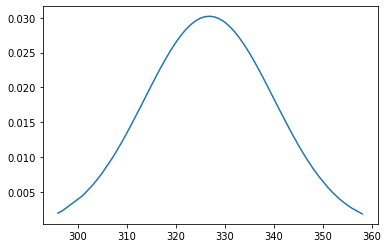

In [33]:
student_monitoring (300)

In [ ]:
def symmetry (students):
    
    